In [12]:
import os
import random
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from dotenv import load_dotenv
# Load the API key from the .env file
load_dotenv()
IBM_TOKEN = os.getenv('IBM_TOKEN')
IBMQ.delete_account()
IBMQ.save_account(IBM_TOKEN)
IBMQ.load_account()

# Define functions to simplify interactions with quantum computers
def get_quantum_computer(qubits=2, simulation=False, verbose=False):
    # Finds a quantum computer at IBM with the lowest queue as long as it has enough qubits for the circuit
    if simulation == False: # Execute the circuit on a quantum computer at IBM
        lowest = float('inf')
        provider = IBMQ.get_provider(hub='ibm-q')
        for backend in provider.backends():
            try:
                if "simulator" not in backend.name():
                    queue = backend.status().pending_jobs
                    qubit_count = len(backend.properties().qubits)
                    if qubit_count >= qubits:
                        if queue < lowest:
                            lowest = queue
                            quantum_computer = provider.get_backend(backend.name())
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {queue} queued jobs and {qubit_count} qubits")
                    else:
                        if verbose == True:
                            print(f"Quantum Computer {backend.name()} has {qubit_count} qubits, but we need {qubits} qubits")
            except:
                print(f"Quantum Computer {backend.name()} is not operational")
        if quantum_computer is None:
            print(f"No Quantum Computers available with {qubits} qubits, using simulator")
    if simulation == True or quantum_computer is None: # Execute the circuit on the simulator
        quantum_computer = Aer.get_backend('qasm_simulator')
        if verbose == True:
            print(f"Using Quantum Computer Simulator")
    if verbose == True and simulation == False:
        print(f"Using Quantum Computer: {quantum_computer.name()} with {quantum_computer.status().pending_jobs} queued jobs")
    return quantum_computer

def prepare_quantum_circuit(qubits=2, classical_bits=2, simulation=False, verbose=False):
    # Create registers for the circuit
    quantum_register = QuantumRegister(qubits)
    classical_register = ClassicalRegister(classical_bits)
    # Create a Quantum Circuit
    quantum_circuit = QuantumCircuit(quantum_register, classical_register)
    # Get a quantum computer with at least the number of selected qubits for the circuit and the lowest queue, or the simulator
    quantum_computer = get_quantum_computer(qubits=qubits, simulation=simulation, verbose=verbose)
    return quantum_circuit, quantum_register, classical_register, quantum_computer

def execute_quantum_circuit(quantum_circuit, quantum_computer, shots=500, verbose=False):
    queue_position = quantum_computer.status().pending_jobs + 1
    if verbose == True:
        print(f"Your job is number {queue_position} in the queue on {quantum_computer.name()}.  Please wait...")
    result = execute(quantum_circuit, backend=quantum_computer, shots=shots).result()
    counts = result.get_counts(quantum_circuit)
    if verbose == True:
        print(f"{result.status} in {result.time_taken} seconds on {quantum_computer.name()}")
    highest_probable = result.get_counts(quantum_circuit).most_frequent()
    if verbose == True:
        probability = 100 * float(result.get_counts(quantum_circuit)[highest_probable])/float(shots)
        print(f"The probable result was {highest_probable} with {probability}% probability")
    return highest_probable, result, counts

def bell_state_circuit(quantum_circuit, quantum_register, classical_register):
    # Build a Bell State circuit
    # https://en.wikipedia.org/wiki/Bell_state
    quantum_circuit.h(quantum_register[0])
    quantum_circuit.cx(quantum_register[0], quantum_register[1])
    quantum_circuit.measure(quantum_register, classical_register)
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def brute_force_circuit(quantum_circuit, quantum_register, classical_register):
    # Build a brute force circuit using 3 qubits
    # https://en.wikipedia.org/wiki/Quantum_logic_gate#Quantum_logic_gates
    quantum_circuit.h(quantum_register[0])
    quantum_circuit.x(quantum_register[1])
    quantum_circuit.cx(quantum_register[0], quantum_register[1])
    quantum_circuit.h(quantum_register[2])
    quantum_circuit.cx(quantum_register[1], quantum_register[2])
    quantum_circuit.measure(quantum_register, classical_register)
    drawing = quantum_circuit.draw()
    return quantum_circuit, drawing

def iterate_words(words, shots=500, verbose=False):
    new_words = {}
    for word in words:
        quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=3, classical_bits=3, simulation=True, verbose=True)
        quantum_circuit, drawing = brute_force_circuit(quantum_circuit, quantum_register, classical_register)
        highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=shots, verbose=True)
        
        if highest_probable not in new_words:
            new_words[highest_probable] = word
        else:
            # I didn't like that answer, try again with less shots!
            if shots > 1:
                shots = int(shots/2)
            else:
                # We have exhausted our options, the gods have willed that this is not an option.
                continue
            new_words = iterate_words(words, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=shots, verbose=verbose)
    return new_words


def brute_force(words, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=500, verbose=False):
    # Lets do something silly.  Lets brute force a password if there are only 8 possible passwords.
    # We could wrap this in a function and pass in a dictionary then make this roll a probability for each, but we will just use a list for now.
    # There is no way this can be accurate, but it is fun to see the results.
    # Shuffle the list of words so that they're essentially in super position until observed below.
    quantum_circuit, drawing = brute_force_circuit(quantum_circuit, quantum_register, classical_register)
    highest_probable, result, counts = execute_quantum_circuit(quantum_circuit, quantum_computer, shots=shots, verbose=True)
    random.shuffle(words)
    probabilities = {}
    # This isn't working below - I need to find a way to match a word randomly to each result and then calculate the probability of each word.
    for key, value in counts.items():
        for word in words:
            if word not in probabilities.keys():
                probability = 100 * float(value)/float(shots)
                probabilities[word] = f"{probability}%"

    return probabilities, drawing, highest_probable, result, counts

ibmqfactory.load_account:WARNING:2023-01-10 17:57:55,833: Credentials are already in use. The existing account in the session will be replaced.


In [13]:
# Set up the circuit
quantum_circuit, quantum_register, classical_register, quantum_computer = prepare_quantum_circuit(qubits=3, classical_bits=3, simulation=False, verbose=True)
# Run a brute force on the words list
words = ["password1", "password2", "password3", "password4", "password5", "password6", "password7", "password8"]
probabilities, drawing, highest_probable, result, counts = brute_force(words, quantum_circuit, quantum_register, classical_register, quantum_computer, shots=500, verbose=True)
drawing


Quantum Computer ibmq_lima has 36 queued jobs and 5 qubits
Quantum Computer ibmq_belem has 23 queued jobs and 5 qubits
Quantum Computer ibmq_quito has 0 queued jobs and 5 qubits
Quantum Computer ibmq_manila has 8 queued jobs and 5 qubits
Quantum Computer ibm_nairobi has 59 queued jobs and 7 qubits
Quantum Computer ibm_oslo has 14 queued jobs and 7 qubits
Using Quantum Computer: ibmq_quito with 0 queued jobs
Your job is number 1 in the queue on ibmq_quito.  Please wait...
Successful completion in 2.374215602874756 seconds on ibmq_quito
The probable result was 010 with 28.6% probability


┌───┐          ┌─┐      
q15_0: ┤ H ├──■───────┤M├──────
       ├───┤┌─┴─┐     └╥┘┌─┐   
q15_1: ┤ X ├┤ X ├──■───╫─┤M├───
       ├───┤└───┘┌─┴─┐ ║ └╥┘┌─┐
q15_2: ┤ H ├─────┤ X ├─╫──╫─┤M├
       └───┘     └───┘ ║  ║ └╥┘
 c3: 3/════════════════╩══╩══╩═
                       0  1  2

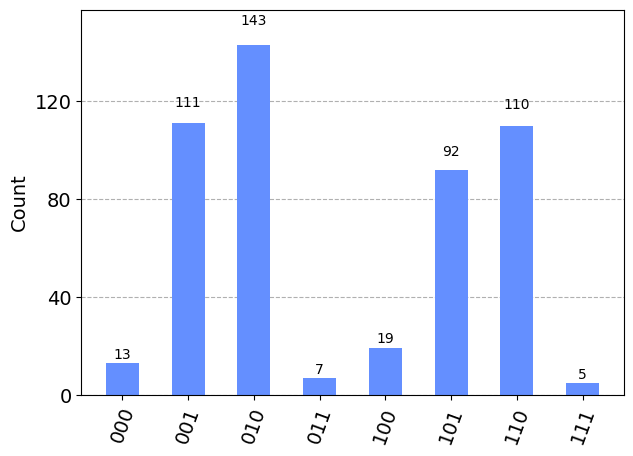

In [14]:
plot_histogram(counts)

In [15]:
print(probabilities)

{'password6': '2.6%', 'password7': '2.6%', 'password2': '2.6%', 'password3': '2.6%', 'password8': '2.6%', 'password4': '2.6%', 'password5': '2.6%', 'password1': '2.6%'}
